In [1]:
import configs.GoogleMapsAPI as gmaps
import pandas as pd
import requests

In [2]:
URL = "https://maps.googleapis.com/maps/api/elevation/json?locations={}&key=" + gmaps.APIKEY


In [3]:
def get_elevations(geocoordinates):
    
    locations = None
    for coordinate in geocoordinates:
        lat, lon = coordinate
        if locations is None:
            locations = f'{lat}%2C{lon}'
        else:
            locations = f'{locations}%7C{lat}%2C{lon}'
        
    url = URL.format(locations)
    #print (url)
    payload={}
    headers = {}

    response = requests.request("GET", url, headers=headers, data=payload)
    return response

In [4]:
if False:
    locations = [
        [40.714728, -73.998672],
        [40.71, -73.9983],
    ]

    response = get_elevations(locations)
    print (response.text)

In [5]:
rawdf = pd.read_csv('./data/Elevation/HumpedCrossing.csv')
print (rawdf.shape)
print (rawdf.columns)
rawdf.head()

(13040, 19)
Index(['Counter', 'date', 'latitude', 'longitude', 'elevation',
       'Elevation (ft)', 'planar_deviation', 'Planar Deviation (ft)',
       'Planar Deviation (in)', 'block_length', 'z_range', 'FRA_DB#',
       'railroad', 'MP', 'street', 'city', 'state', 'angle_range',
       'lowgc_signs#'],
      dtype='object')


,Counter,date,latitude,longitude,elevation,Elevation (ft),planar_deviation,Planar Deviation (ft),Planar Deviation (in),block_length,z_range,FRA_DB#,railroad,MP,street,city,state,angle_range,lowgc_signs#
0,1,20191216,38.525221,-78.585675,271.100000,889.435695,2.644013,8.674583,104.094999,0.000000,17.677264,468728T,NS,101.4,COLD SPRINGS DRIVE,SHENANDOAH,VA,NaN,NaN
1,2,20191213,37.205641,-80.293657,410.906915,1348.119799,2.445426,8.023050,96.276599,0.186293,6.093171,469500W,NS,267.6,NaN,NaN,VA,NaN,NaN
2,3,20191216,38.805243,-78.349207,208.500000,684.055118,2.403641,7.885960,94.631524,0.123313,14.993995,468667E,NS,75.5,overall road,BENTONVILLE,VA,NaN,NaN
3,4,20191216,39.459869,-77.764867,141.755539,465.077226,2.352856,7.719344,92.632125,0.398835,32.190927,469335N,NS,13.4,SNYDERS LNDG RD,ST JAMES,MD,NaN,NaN
4,5,20200109,36.746844,-83.690274,320.404333,1051.195317,2.323092,7.621693,91.460315,0.000000,10.391219,344961H,CSX,204.36,PUBLIC ROAD,CARRIGAN,KY,NaN,NaN


In [6]:
def get_elevation(df):
    """ Gets elevations for a dataframe based on latitude and longitude columns
    Args:
        df (pandas.DataFrame): input dataframe

    Returns:
        (DataFrame, response):
            DataFrame: input dataframe with GoogleElevation and GoogleResolution columns
            response: response from Google Maps API
    """
    locations = list(zip(df.latitude, df.longitude))
    response = get_elevations(locations)
    df['GoogleElevation'] = [x['elevation'] for x in response.json()['results']]
    df['GoogleResolution'] = [x['resolution'] for x in response.json()['results']]
    return df, response

In [12]:
i = 0
while i < len(rawdf):
    tmp = rawdf.iloc[i:i+512].copy()
    tmp, response = get_elevation(tmp)
    if i == 0:
        df = tmp
    else:
        df = pd.concat([df, tmp])
    i += 512
    print (f'Processing row {i}/{len(rawdf)}.\r', end='')

df.to_csv('./data/Elevation/HumpedCrossingGoogleElevation.csv', index=False)


In [15]:
df['ElevationDiff'] = df.elevation - df.GoogleElevation
df['ElevationDiffAbs'] = df.ElevationDiff.abs()
df[['elevation', 'GoogleElevation', 'ElevationDiff', 'ElevationDiffAbs']].describe()

,elevation,GoogleElevation,ElevationDiff,ElevationDiffAbs
count,13040.000000,13040.000000,13040.000000,13040.000000
mean,329.048797,337.948453,-8.899656,15.302788
std,354.906004,359.081754,30.585896,27.937676
min,-1.300000,-41.918465,-462.099793,0.000089
25%,114.100000,115.049194,-10.319848,2.847165
50%,214.600000,219.800751,0.336307,6.385711
75%,376.225000,398.498863,5.079568,14.382701
max,2210.870835,2263.018066,51.607355,462.099793


<AxesSubplot:ylabel='Frequency'>

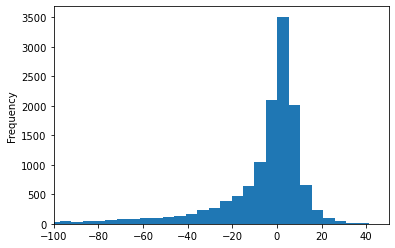

In [26]:
df.ElevationDiff.plot.hist(bins=100, xlim=(-100, 50))

<AxesSubplot:>

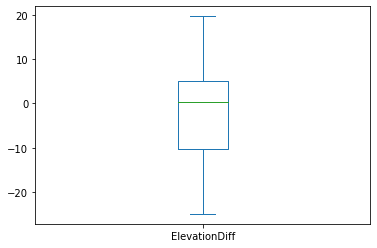

In [25]:
df.ElevationDiff.plot.box(showfliers=False, whis=0.95)

In [ ]:
print(response.text)